In [1]:
import torch
from torch.nn import *
import torch.nn.functional as F
from pandas_datareader import data as web
import os
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from diebold_mariano import diebold_mariano_test

In [2]:
from utils import *

DEVICE:  cuda


In [3]:
T=30

In [4]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

# Set consistent style for publication-quality plots
sns.set(style="whitegrid", context="talk", palette="colorblind")
matplotlib.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "legend.frameon": True,
    "axes.titleweight": "bold"
})

def customize_ax(ax, title=None, xlabel=None, ylabel=None):
    if title:
        ax.set_title(title, fontsize=14, fontweight="bold")
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=12)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.grid(True)
    if ax.get_legend():
        ax.legend(fontsize=10, frameon=True)

# Insert your original loop code here afterward, using customize_ax() and matplotlib.rcParams updates
# on all relevant plots to ensure publication-quality formatting.


In [5]:
etfs = ['XLB','XLE','XLF','XLI','XLK','XLP','XLV','XLY','XLU']
metric2 = "Squared_Returns"
metric3 = "SD_Prices"
metrics = ["ATR",metric2,metric3]
# start = '2001-01-01'
# end = '2020-01-01'
# start_t = '2022-01-02'
# end_t = '2024-01-05'
date_list = [['2001-01-01', '2020-01-01', '2022-01-02', '2024-01-05'], ['1990-01-05', '2010-01-05', '2023-01-05', '2024-01-05'], ['2000-01-05', "2024-01-05", "2024-01-05", "2025-01-05"], ['2005-01-05', '2010-01-05', '2020-01-05', '2024-01-05']]
starts,ends = np.array([(f'200{i}-01-01',f'200{i+12}-01-01') for i in range(0,12,4)]).T
models = {}
lrs = [0]
h1 = 50
h2 = 50
hl1s = [20,50,70,100]
hl1s = [20,50,70,100]
models = ["LSTM","RNN"]
b_types = ['ATR' ,'STD']
lr = 0
feat_combos = [['Open','Close','High','Low','Volume','Return','Short_MA','Long_MA'],['Open','Close','High','Low','Volume'],['index','Open','Close','High','Low','Volume']]

[*********************100%***********************]  1 of 1 completed


read  4779  lines of data for ticker:  XLB


RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


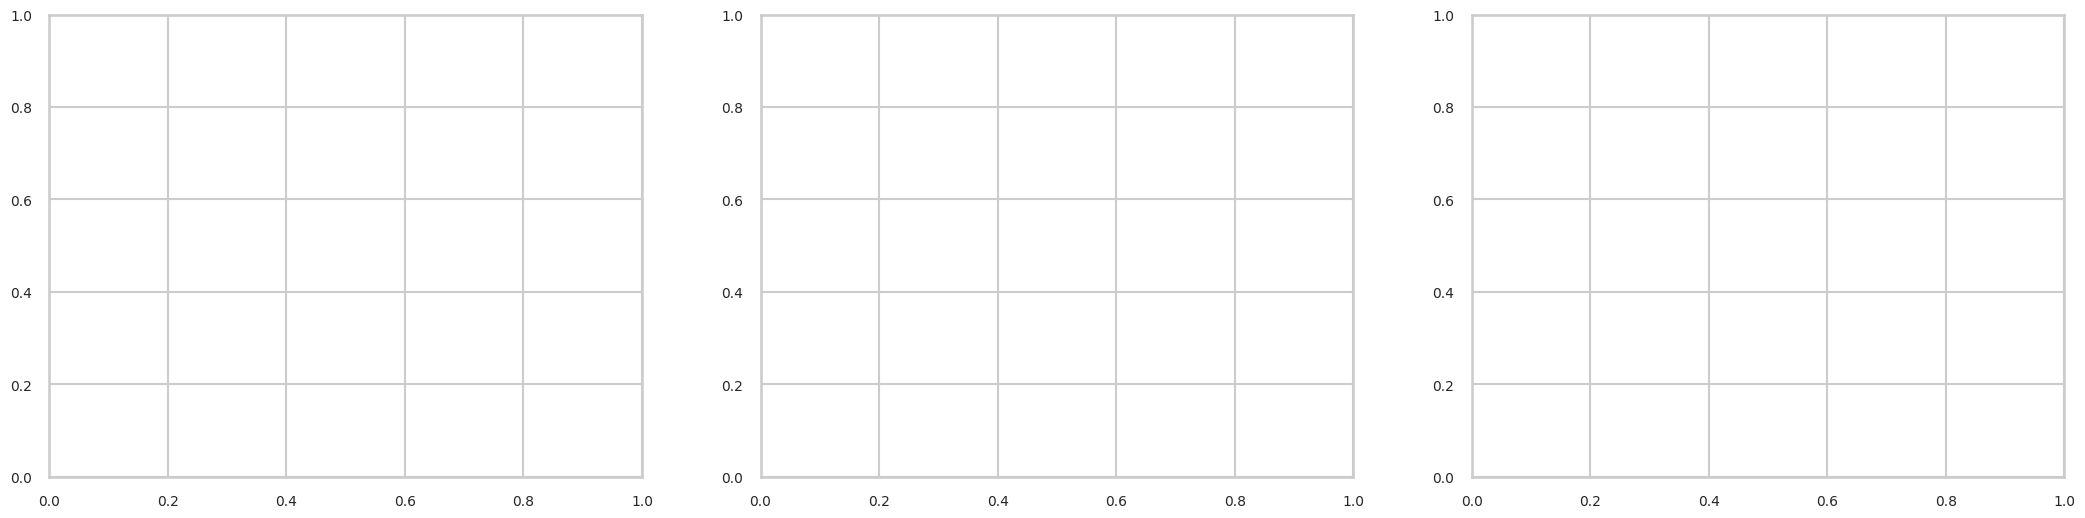

In [6]:
num=10000
for file in os.listdir('../output'):
    if "runtest" in file:
        num+=1
os.mkdir(f'../output/runtest_{num}')
for d,(start,end,start_t,end_t) in enumerate(date_list):
    os.mkdir(f'../output/runtest_{num}/date_config{d}')
    for model_type in models:
        os.mkdir(f'../output/runtest_{num}/date_config{d}/{model_type}')
        root = f'../output/runtest_{num}/date_config{d}/{model_type}'
        with open(os.path.join(root,'run_data.txt'),'w') as f:
            f.write(f'Start Training Date: {start} \n End Training Date: {end} \n Start Sim Date: {start_t} \n End Sim Date: {end_t} \n')
            f.write(f'\n Model Type: {model_type}')
            f.write(f'Look-back window: {T} days')

        for etf in etfs:
            os.mkdir(f'{root}/{etf}')
        for lr in lrs:
            results = pd.DataFrame({"ETF":[],"Metric":[],"Final_Value":[],"Passive_Potential":[],"Relative_MSE":[],"MAPE":[],"DM_stat":[],"DM_p":[]})
            money_df_std = pd.DataFrame()
            money_df_atr = pd.DataFrame()
            money_df_sd_prices = pd.DataFrame()
            money_df_passive = pd.DataFrame()
            for j,etf in enumerate(etfs):
                fig,ax = plt.subplots(1,len(metrics),figsize=(26,6))
                atr_preds = []
                for i,metric in enumerate(metrics):
                    scaler = StandardScaler()
                    scaler_x = StandardScaler()
                    df = get_cleaned_df(etf,start,end)
                    #print(df)
                    model,fig_tr,fig_te = get_trained_model(df,scaler, scaler_x, metric=metric,model_type=model_type)
                    fig_tr.savefig(os.path.join(root,etf,f'training_results_{metric}'))
                    fig_te.savefig(os.path.join(root,etf,f'testing_results_{metric}'))
                    df_test = get_cleaned_df(etf,start_t,end_t)
                    ini_cash = 10000
                    final_value, money, shares,passive_value,buy_points,sell_points,preds, t_money,p_money = backtest_strategy_mr(df_test,model,scaler,scaler_x,metric,sell_scale=2,buy_scale=2)
                    print(f"{etf} Final Value: {final_value}, Final Money: {money}, Final Shares: {shares}")
                    
                    real_met = np.array(df_test[metric].iloc[T:len(df_test)-1])
                    atr_met = np.array(df_test["ATR"].iloc[T:len(df_test)-1])
                    null_model_error = np.sum((real_met-real_met.mean())**2)
                    mse_error = 1/len(real_met) * np.sum((real_met-preds)**2)/null_model_error
                    mape_error = 1/len(real_met) * np.sum(abs(real_met-preds)/(real_met+1e-8))
                    if metric=="ATR": #atr should go first
                        money_df_atr[etf] = t_money
                        atr_preds = preds
                    elif metric=="Squared_Returns":
                        money_df_std[etf] = t_money
                        money_df_passive[f"{etf}_Passive"] = p_money
                    elif metric == "SD_Prices":
                        money_df_sd_prices[etf] = t_money

                    dm,p = diebold_mariano_test(atr_met,atr_preds,real_met,preds,loss="mae")
                    results.loc[len(results)] = [etf,metric,final_value,passive_value,mse_error,mape_error,dm,p]

                    sns.lineplot(preds,ax=ax[i],label=f"Prediction {metric}",color="Blue")
                    sns.lineplot(real_met,ax=ax[i],label = f"True {metric}",color="Orange")
                    #for buy in buy_points:
                        #ax[i].axvline(buy,color="Green",alpha=.6)
                    #for sell in sell_points:
                        #ax[i].axvline(sell,color="Red",alpha=.6)
                    ax[i].set_title(f"{etf} - {metric} ")
                    ax[i].set_xlabel(f'| Total MSE Error {mse_error:.6f} | Total MAPE Error: {mape_error:.3f} | Total DM Score: {dm:.2f},{p:.2f}"')
                    customize_ax(ax[i])
                    #plt.title(f"Performance of LSTM on {etf}")
                fig.supylabel("Volatility Metric")
                fig.supxlabel(f"Days after {start_t}")
                fig.tight_layout()
                fig.savefig(os.path.join(root,etf,'predictions_lr_{lr}.png'))
                fig_sim,ax_sim = plt.subplots(figsize=(10,3))
                sns.lineplot(x=range(0, len(df_test.index)-(T+1)), y=money_df_atr[etf], label="ATR",ax=ax_sim)
                sns.lineplot(x=range(0,len(df_test.index)-(T+1)),y=money_df_std[etf],label="STD",ax=ax_sim)
                sns.lineplot(x=range(0,len(df_test.index)-(T+1)),y=money_df_sd_prices[etf],label="SD_Prices",ax=ax_sim)
                sns.lineplot(x=range(0,len(df_test.index)-(T+1)),y=money_df_passive[f"{etf}_Passive"],label="Passive",ax=ax_sim)
                ax_sim.axhline(1000, label = "Initial",color="Black")
                ax_sim.set_xlabel(f"Days after {start_t}")
                ax_sim.set_title(f"ETF Performance Over Time for {etf}")
                customize_ax(ax_sim)
                fig_sim.savefig(os.path.join(root,etf,'simulation_perf_lr_{lr}'))
                
            fig2,ax2 = plt.subplots(figsize = (8,6))
            sns.barplot(data=results,x="ETF",y="Final_Value",hue="Metric",ax=ax2)    
            plt.legend(loc=(1.1,1))
            fig2.tight_layout()
            customize_ax(ax2)
            fig2.savefig(os.path.join(root,'return_metrics_lr_{lr}.png'))
            results.to_csv(os.path.join(root,'overall_results.csv'),index=False)

In [15]:
os.listdir()

['get_stock_data.ipynb',
 'predictions_lr_0.05.png',
 'predictions_lr_0.png',
 'sim.ipynb',
 'predictions_lr_0.01.png',
 'read_stock_data_from_file.py',
 'testing.ipynb',
 'predictions_lr_0.125.png',
 '__pycache__',
 'full_sim_tests.ipynb',
 'predictions.png',
 'all_etfs_sim.png',
 'predictions_lr_0.5.png',
 'Clean_Data.csv',
 'utils.py',
 'predictions_lr_0.0.png',
 'TSLA.csv',
 'predictions_lr_0.1.png',
 'SPY.csv',
 'planning.txt',
 'return_metrics.png',
 'predictions_lr_0.25.png',
 'predictions_lr_0.375.png',
 'read_and_save_stock_data.py']

In [17]:
for i in range(32,41):
    df = pd.read_csv(f'runtest_{i}/overall_results.csv')
    print(i,df.groupby('Metric')['Relative_MSE'].mean())

32 Metric
ATR                0.830029
Squared_Returns    0.895952
Name: Relative_MSE, dtype: float64
33 Metric
ATR                0.771406
Squared_Returns    0.628715
Name: Relative_MSE, dtype: float64
34 Metric
ATR                0.799177
Squared_Returns    0.824391
Name: Relative_MSE, dtype: float64
35 Metric
ATR                0.724802
Squared_Returns    0.823542
Name: Relative_MSE, dtype: float64
36 Metric
ATR                0.794125
Squared_Returns    0.964812
Name: Relative_MSE, dtype: float64
37 Metric
ATR                0.680897
Squared_Returns    0.544277
Name: Relative_MSE, dtype: float64
38 Metric
ATR                0.751495
Squared_Returns    0.594292
Name: Relative_MSE, dtype: float64
39 Metric
ATR                0.628070
Squared_Returns    0.565187
Name: Relative_MSE, dtype: float64
40 Metric
ATR                0.751546
Squared_Returns    0.677466
Name: Relative_MSE, dtype: float64


In [14]:
os.getcwd()

'/project/rise-portfolio/lstm-atr-prediction/stock-data'

In [18]:
folders = [dir for dir in os.listdir() if "runtest" in dir]
for folder in folders:
    overall_results = pd.read_csv(f'./{folder}/overall_results.csv')
    print("Runtest: ",folder,"Mean MSE over all sectors: ",overall_results.groupby("Metric")["Relative_MSE"].mean(numeric_only=True))

Runtest:  runtest_105 Mean MSE over all sectors:  Metric
ATR                0.681602
Squared_Returns    1.110356
Name: Relative_MSE, dtype: float64
Runtest:  runtest_rnn_no_index Mean MSE over all sectors:  Metric
ATR                0.577091
Squared_Returns    0.518700
Name: Relative_MSE, dtype: float64
Runtest:  runtest_rnn_scaled_feats Mean MSE over all sectors:  Metric
ATR                0.546472
Squared_Returns    0.981297
Name: Relative_MSE, dtype: float64
Runtest:  runtest_104 Mean MSE over all sectors:  Metric
ATR                0.632142
Squared_Returns    1.119568
Name: Relative_MSE, dtype: float64
Runtest:  runtest_106 Mean MSE over all sectors:  Metric
ATR                0.692127
Squared_Returns    1.005954
Name: Relative_MSE, dtype: float64


In [14]:
overall_results

,ETF,Metric,Final_Value,Passive_Potential,Relative_MSE
0,XLB,ATR,1051.459404,1030.095425,0.986951
1,XLB,Squared_Returns,1000.000000,1030.095425,0.573459
2,XLE,ATR,861.108548,1257.954208,0.049186
3,XLE,Squared_Returns,854.374963,1257.954208,0.219141
4,XLF,ATR,837.852820,985.837923,0.074326
5,XLF,Squared_Returns,968.250000,985.837923,0.333424
6,XLI,ATR,1097.155597,1146.831530,1.298836
7,XLI,Squared_Returns,1000.000000,1146.831530,4.525363
8,XLP,ATR,966.546078,975.665810,0.566123
9,XLP,Squared_Returns,1000.000000,975.665810,0.406951
